# Visualizing Processed Labels
This notebook takes analyzes processed labels to ensure consistency.

In [1]:
!pip install seaborn -q
!pip install altair -q

In [2]:
from datetime import timedelta
from shapely.geometry import Point
from pyproj import Transformer
from tqdm.notebook import tqdm
import altair as alt
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

import sys
sys.path.append("..")

from src.dataset_config import labeled_datasets
from utils import get_dvc_dir

NameError: name 'EarthEngineExporter' is not defined

# Read in data

In [3]:
test_dir = get_dvc_dir("test")
africa = geopandas.read_file(test_dir / "afr_g2014_2013_0")

In [46]:
get_dvc_dir("processed")
df = pd.concat([pd.read_csv(d.labels_path) for d in labeled_datasets])

In [71]:
from pathlib import Path
import pickle

In [72]:
import os

In [89]:
sys.path.insert(0, '/Users/izvonkov/nasaharvest/togo-crop-mask/')

In [90]:
os.getcwd()

'/Users/izvonkov/nasaharvest/togo-crop-mask/src'

In [83]:
p = "../data/features/geowiki_landcover_2017/training/0_2017-03-28_2018-03-28.pkl"
with Path(p).open("rb") as f:
    target_datainstance = pickle.load(f)

ModuleNotFoundError: No module named 'src.utils.regions'; 'src.utils' is not a package

# Checking Label Distributions

In [231]:
df["geometry"] = [Point(xy) for xy in zip(df["lon"], df["lat"])]
df.head()

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country,geometry
0,-179.750000,71.452381,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-179.75 71.45238095000001)
1,-175.047619,-19.750000,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-175.047619 -19.75)
2,-172.250000,-13.547619,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-172.25 -13.54761905)
3,-164.750000,62.452381,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,validation,global,POINT (-164.75 62.45238095)
4,-163.250000,62.452381,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-163.25 62.45238095)


In [232]:
def plot_country_specific_labels(df, hue):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.countplot(ax=ax, data=df, x='country', hue=hue)
    sns.despine()
    ax.set_title(f"Country Specific Labels Distribution by {hue}");

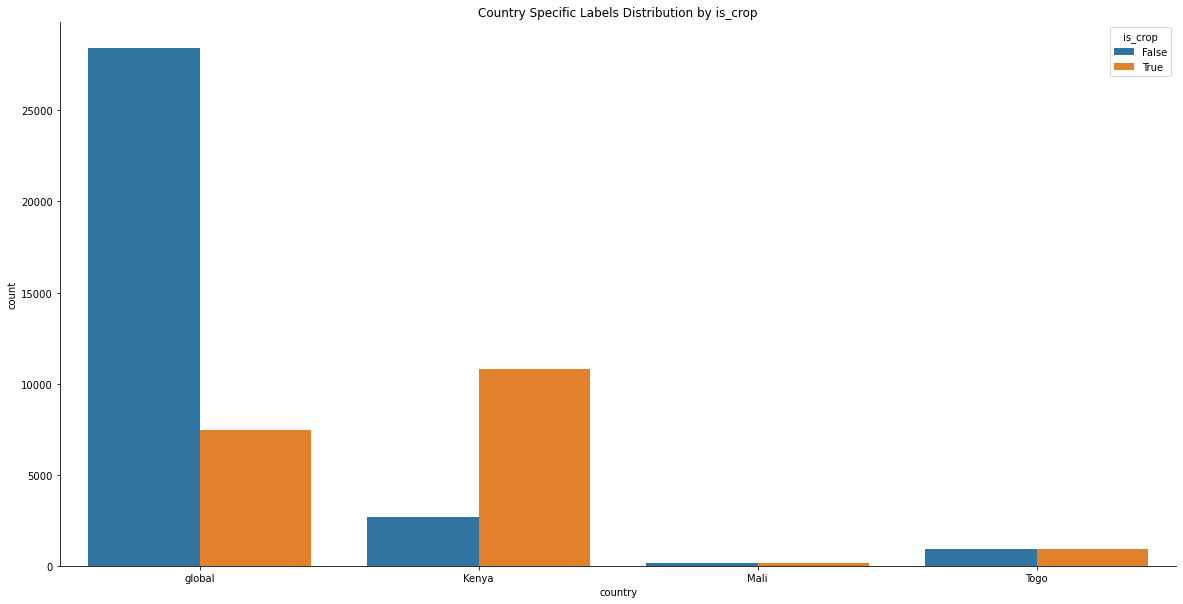

In [233]:
df["is_crop"] = df["crop_probability"] > 0.5 
plot_country_specific_labels(df, "is_crop")

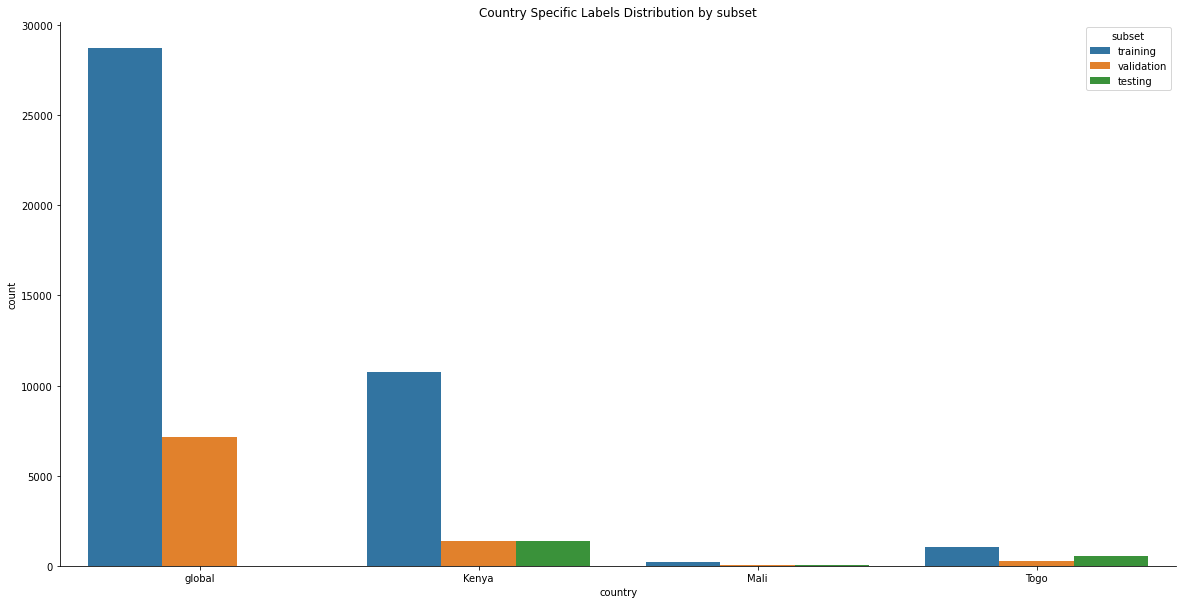

In [234]:
plot_country_specific_labels(df, "subset")

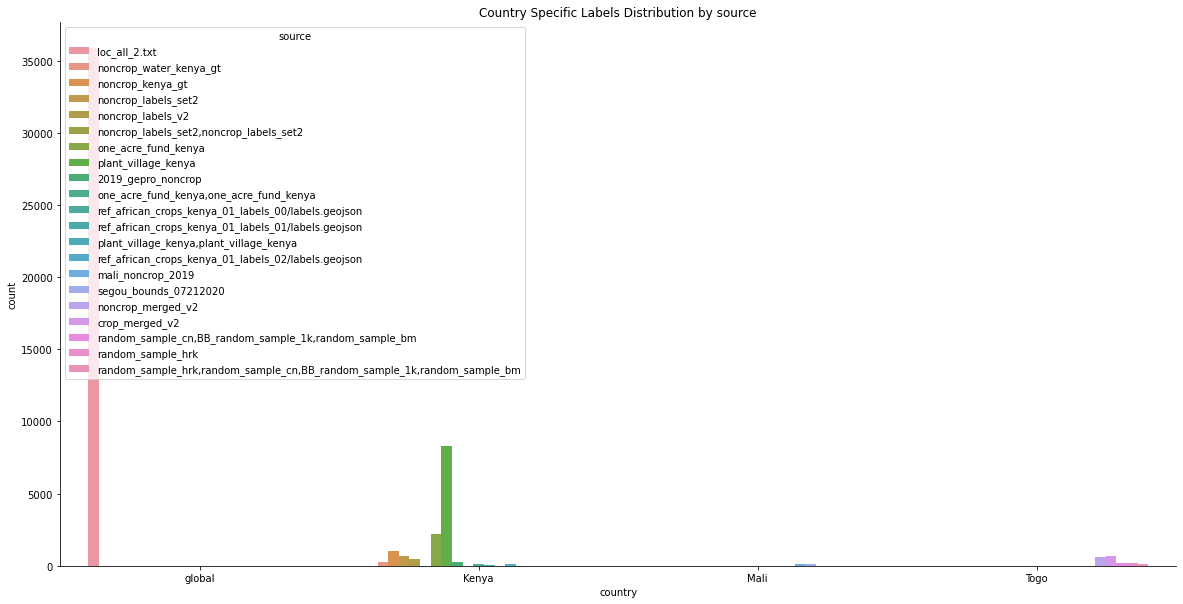

In [235]:
plot_country_specific_labels(df, "source")

In [236]:
df_non_global = geopandas.GeoDataFrame(df[df['country'] != "global"])

def within_country(point: Point, country: str, pbar):
    pbar.update(1)
    return point.within(africa[africa["ADM0_NAME"] == country]["geometry"].iloc[0])


with tqdm(total=len(df_non_global)) as pbar:
    df_non_global["point_within_country"] = np.vectorize(within_country)(df_non_global["geometry"], df_non_global["country"], pbar)

  0%|          | 0/15616 [00:00<?, ?it/s]

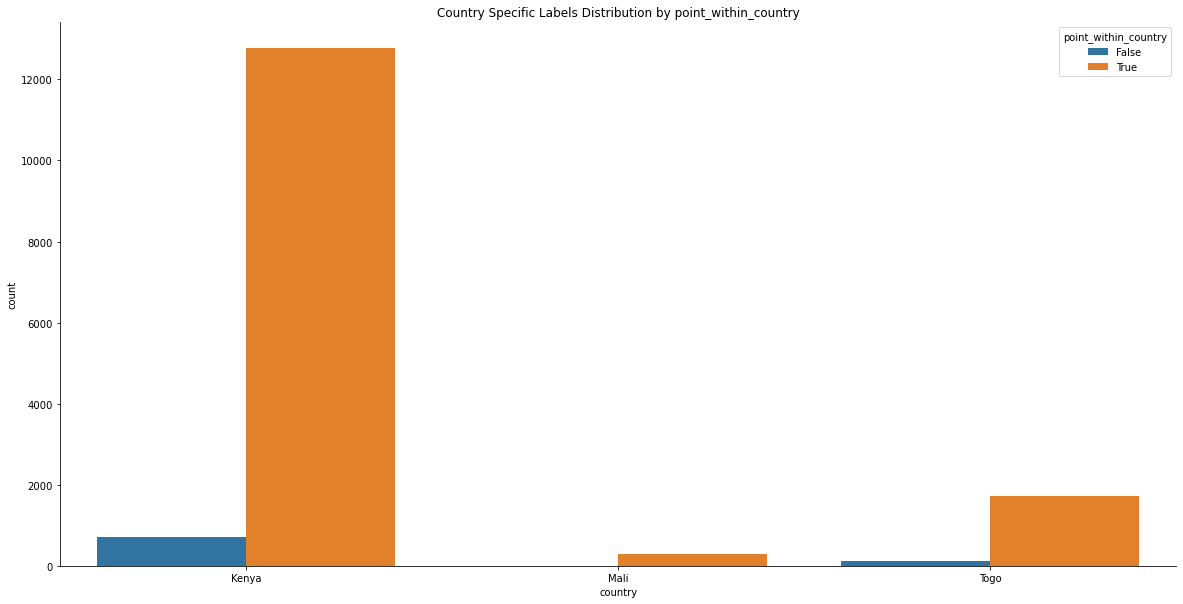

In [237]:
plot_country_specific_labels(df_non_global, "point_within_country")

In [238]:
df_non_global['country_and_source'] = df_non_global['country'] + "/" + df_non_global['source']

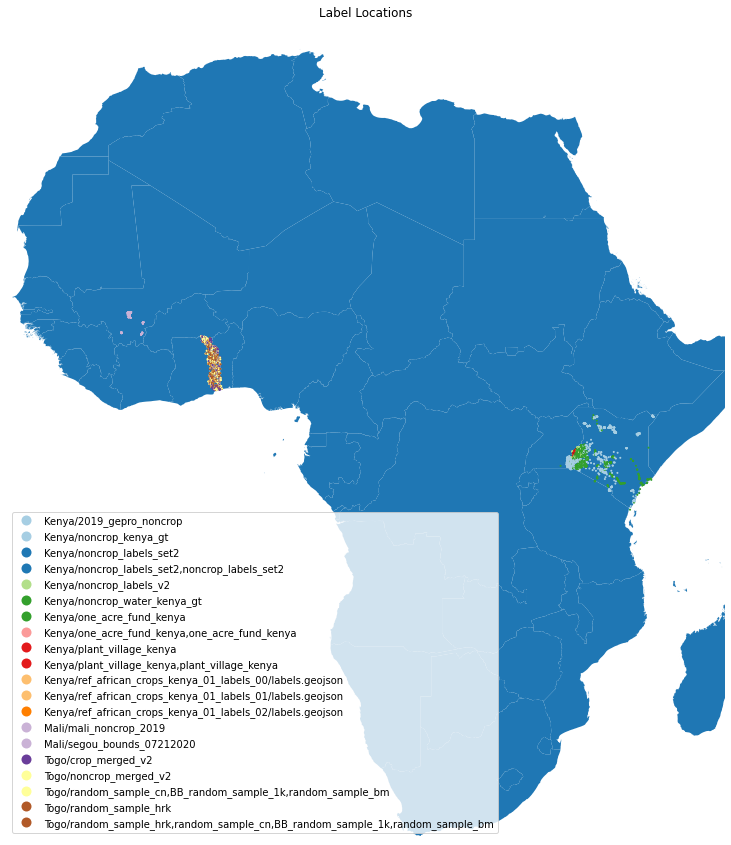

In [239]:
ax=africa.plot(figsize=(15,15))
ax.set_xlim(-18, 48)
ax.set_ylim(-35, 40)
ax.set_title("Label Locations")
ax.axis('off')
df_non_global.plot(
    ax=ax, 
    marker='o', 
    column='country_and_source', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True,
    legend_kwds={'loc': 'lower left'});

## Check Togo test set

In [435]:
togo_test = df[(df['country'] == 'Togo') & 
               (df['subset'] == 'testing') & 
               (df['crop_probability'] != 0.5) & 
               (df['num_labelers'] != 1)]

In [436]:
len(togo_test)

306

In [437]:
togo_test[togo_test['crop_probability'] < 0.5]

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country
116,0.007355,10.780308,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,4,testing,Togo
188,0.174504,10.539371,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.25,4,testing,Togo
242,0.238791,11.049433,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,4,testing,Togo
243,0.238993,9.536434,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,4,testing,Togo
270,0.320139,9.549470,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.25,4,testing,Togo
...,...,...,...,...,...,...,...,...,...
1479,1.556546,7.440474,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,4,testing,Togo
1522,1.599692,8.127404,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,4,testing,Togo
1531,1.604256,9.016346,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,4,testing,Togo
1561,1.620037,8.554501,2019-04-22,2020-04-16,"random_sample_hrk,random_sample_cn,BB_random_s...",0.00,4,testing,Togo


## Checking Plant Village Kenya data

In [47]:
sources = [f"ref_african_crops_kenya_01_labels_0{i}/labels.geojson" for i in [0,1,2]] + ["plant_village_kenya"]
df_new_pv = df[df['source'].isin(sources)] 

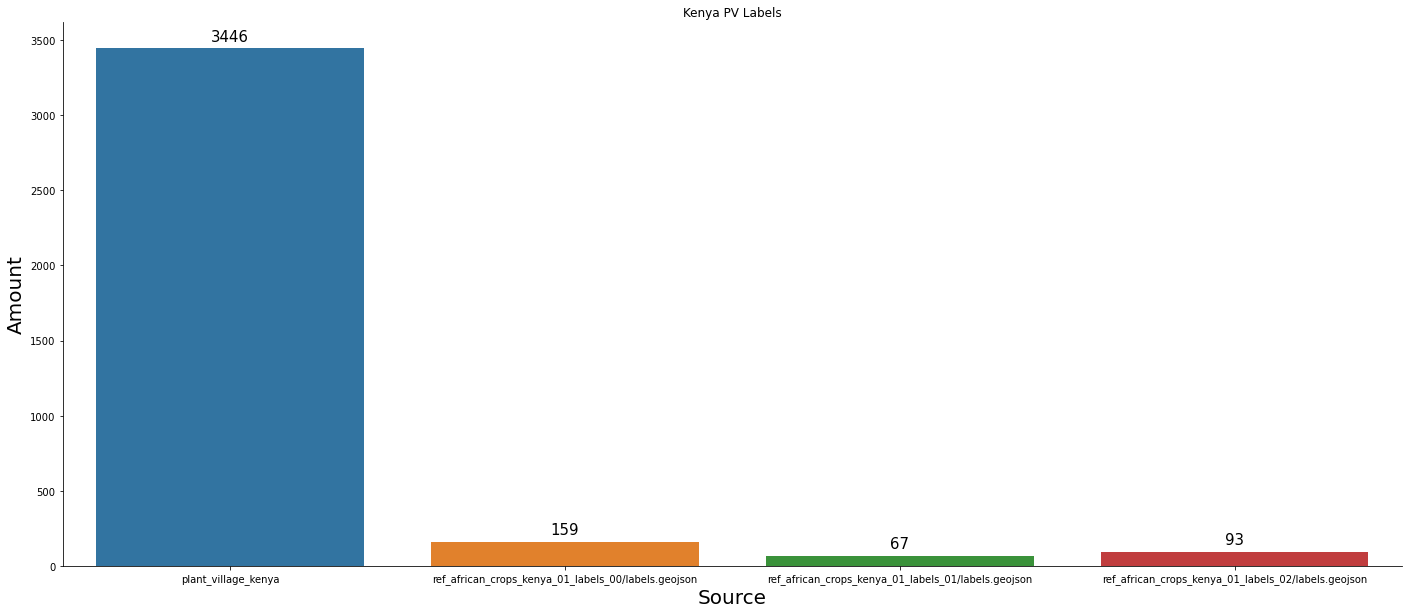

In [48]:
fig, ax = plt.subplots(figsize=(24,10))
sns.countplot(ax=ax, data=df_new_pv, x='source')
sns.despine()
ax.set_title(f"Kenya PV Labels")
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+50), size=15, ha='center')
    
ax.set_xlabel('Source',fontsize=20);
ax.set_ylabel('Amount',fontsize=20);

<AxesSubplot:title={'center':'Kenya Plant Village Label Locations'}>

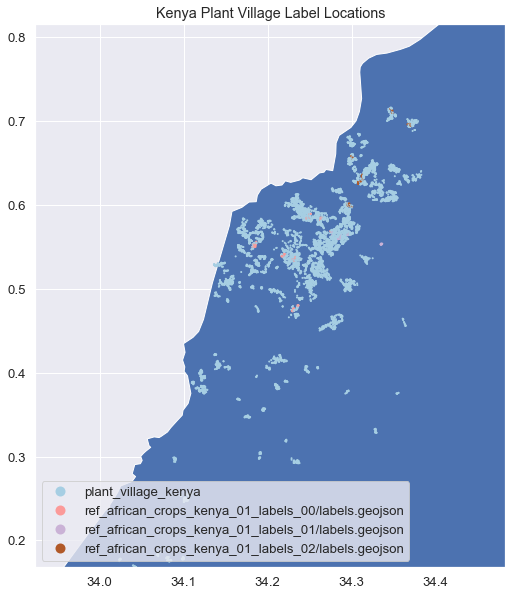

In [384]:
ax=africa[africa['ADM0_NAME'] == 'Kenya'].plot(figsize=(10,10))
ax.set_title("Kenya Plant Village Label Locations")
ax.set_xlim(df_new_pv['lon'].min() - 0.1, df_new_pv['lon'].max() + 0.1)
ax.set_ylim(df_new_pv['lat'].min(), df_new_pv['lat'].max() + 0.1)
geopandas.GeoDataFrame(df_new_pv).plot(
    ax=ax, 
    marker='o', 
    column='source', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True,
    legend_kwds={'loc': 'lower left'})

# Checking Export Date Ranges

In [4]:
date_ranges = df[['start_date', 'end_date', 'source', 'country']].drop_duplicates()

In [5]:
alt.Chart(date_ranges).mark_bar().encode(
    x='start_date',
    x2='end_date',
    y='source'
)

alt.Chart(...)

# Investigating Kenya PV Date Ranges

In [36]:
pv_df = geopandas.read_file(labeled_datasets[1].raw_labels_dir / "plant_village_kenya")

In [37]:
pv_df = pv_df[(pv_df["harvest_da"] != "nan") & (pv_df["harvest_da"] != "unknown")].copy()
len(pv_df)

8278

In [38]:
pv_df['planting_d'] = pd.to_datetime(pv_df['planting_d'])
pv_df['harvest_da'] = pd.to_datetime(pv_df['harvest_da'])
pv_df['between_days'] = (pv_df['harvest_da'] - pv_df['planting_d']).dt.days
pv_df['valid'] = (0 < pv_df['between_days']) & (pv_df['between_days'] < 365)
pv_df['planting_d_str'] = pv_df['planting_d'].dt.strftime("%Y-%m-%d")
pv_df['harvest_da_str'] = pv_df['harvest_da'].dt.strftime("%Y-%m-%d")
pv_df['range'] = pv_df['planting_d_str'] + "_" + pv_df['harvest_da_str']
pv_df.head()

,crop_type,planting_d,harvest_da,density,faw_preval,area,geometry,between_days,valid,planting_d_str,harvest_da_str,range
0,cassava,2018-11-15,2019-01-08,60,0,1010.878746,"POLYGON ((631201.321 61254.609, 631167.878 613...",54,True,2018-11-15,2019-01-08,2018-11-15_2019-01-08
1,intercrop_other,2019-08-08,2020-01-04,60,0,2138.274445,"POLYGON ((631127.970 61218.697, 631095.382 612...",149,True,2019-08-08,2020-01-04,2019-08-08_2020-01-04
2,maize,2019-07-17,2019-01-12,80,3,1021.751644,"POLYGON ((631079.546 61273.780, 631104.387 612...",-186,False,2019-07-17,2019-01-12,2019-07-17_2019-01-12
3,intercrop_maize,2019-07-26,2019-01-12,80,2,5845.948064,"POLYGON ((631316.357 61568.269, 631249.894 616...",-195,False,2019-07-26,2019-01-12,2019-07-26_2019-01-12
4,intercrop_maize,2019-01-08,2019-01-12,80,None,3821.957762,"POLYGON ((631426.161 61595.745, 631425.975 615...",4,True,2019-01-08,2019-01-12,2019-01-08_2019-01-12


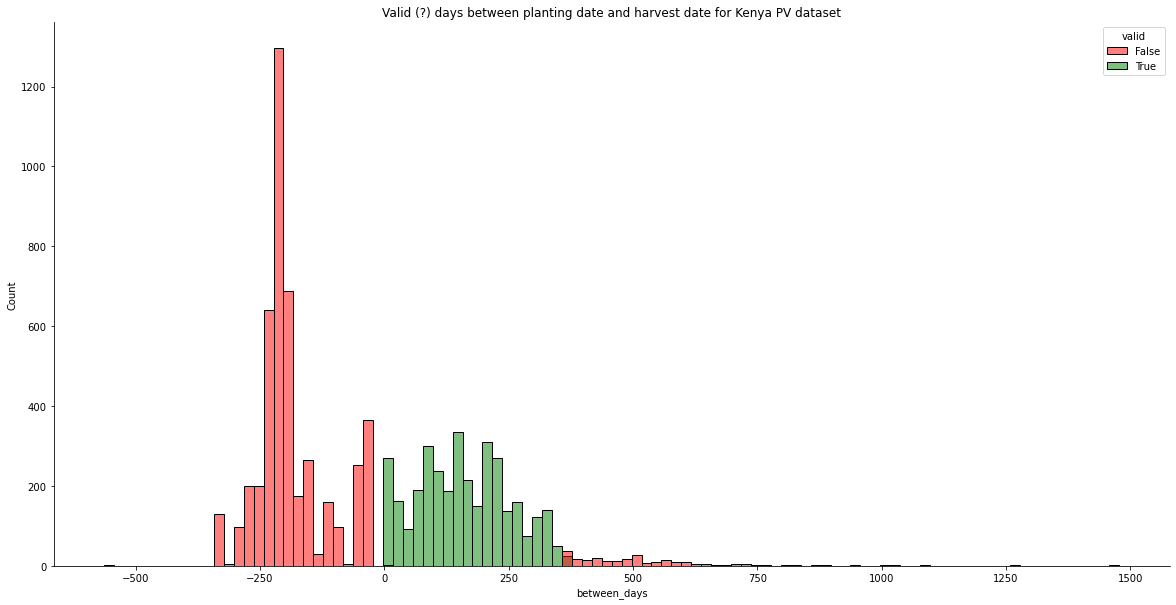

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=pv_df, x='between_days', ax=ax, hue='valid', palette=["red", "green"], binwidth=20)
sns.despine()
ax.set_title("Valid (?) days between planting date and harvest date for Kenya PV dataset");

In [40]:
# Remove invalid years
valid_years = [2018, 2019, 2020]
pv_df = pv_df[(pv_df["planting_d"].dt.year.isin(valid_years)) & (pv_df["harvest_da"].dt.year.isin(valid_years))].copy()
len(pv_df)

8167

In [42]:
pv_df["harvest_da"].dt.year.unique()

array([2019, 2020, 2018])

In [44]:
year = pd.to_timedelta(timedelta(days=365))

# if 0 > between days > -365, increase harvest_da year
mask = (pv_df['between_days'] < 0) & (pv_df['between_days'] > -365)
pv_df.loc[mask, 'harvest_da'] += year

# if 365 < between days > (2*365), decrease harvest_da year
#mask = (pv_df['between_days'] > 365) & (pv_df['between_days'] < (365*2))
#pv_df.loc[mask, 'harvest_da'] -= year

# if 365 < between days > (2*365), decrease harvest_da year
#mask = (pv_df['between_days'] > (365*2)) & (pv_df['between_days'] < (365*3))
#pv_df.loc[mask, 'harvest_da'] -= (2*year)

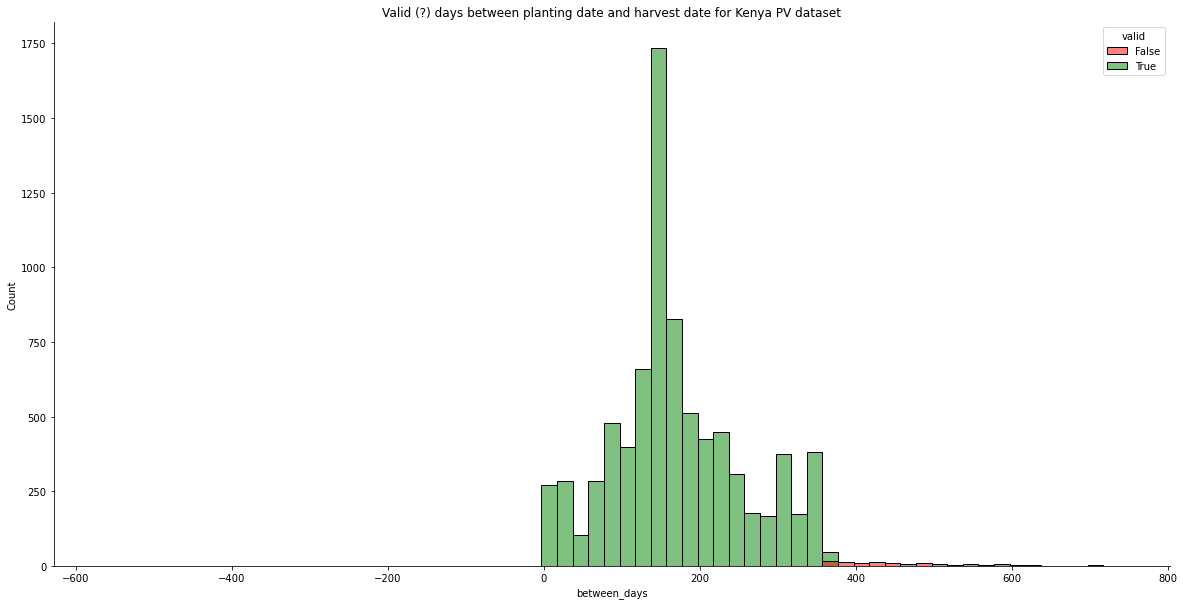

In [45]:
pv_df['between_days'] = (pv_df['harvest_da'] - pv_df['planting_d']).dt.days
pv_df['valid'] = (0 < pv_df['between_days']) & (pv_df['between_days'] <= 365)

fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=pv_df, x='between_days', ax=ax, hue='valid', palette=["red", "green"], binwidth=20)
sns.despine()
ax.set_title("Valid (?) days between planting date and harvest date for Kenya PV dataset");

In [18]:
pv_df['planting_d'].dt.year.unique()

array([2018, 2019, 2017, 2016, 2015])

In [19]:
pv_df['planting_d'].dt.year.value_counts()

2019    7464
2018     773
2017      38
2016       2
2015       1
Name: planting_d, dtype: int64

In [20]:
pv_df['harvest_da'].dt.year.value_counts()

2020    7187
2019    1048
2018      41
2021       1
2017       1
Name: harvest_da, dtype: int64

In [21]:
pv_df[pv_df['harvest_da'].dt.year == 2021]

,crop_type,planting_d,harvest_da,density,faw_preval,area,geometry,between_days,valid,planting_d_str,harvest_da_str,range
7562,intercrop_other,2019-01-08,2021-01-07,90,0,7026.53659,"POLYGON ((646628.009 58937.731, 646588.059 588...",730,False,2019-01-08,2021-01-07,2019-01-08_2021-01-07
